In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()
import pymc as pm
import pytensor as pt
import numpy as np
import pandas as pd
import itertools
import random
import operator
import arviz as az

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import models, utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#32 Haplotypes
#5 placings in the haplotype (2⁵ = 32)
#100 genotypes

haplotypes = list(map(list, itertools.product([0, 1], repeat=5)))
haplotypesProb = [
    0.0056,   0.004,                0.00368,  0.1,                 
    0.005681, 0.09,                 0.00468,  0.003,    
    0.08,     0.006147,             0.00595,  0.0071,   
    0.00345,  0.00632,              0.1,      0.0029,   
    0.0071,   0.006147,             0.085,    0.0045671,
    0.003379, 0.1,                  0.00461,  0.00614,             
    0.075,    0.08,                 0.00761,  0.004321, 
    0.09,     0.009217900000000112, 0.0134,   0.075]

In [3]:
haplotypesnumber = {}
for i in range(32):
    haplotypesnumber[str(haplotypes[i])] = 0

In [4]:
genotypes = []
d = {'h_1': [], 'h_2': [], 'g': []}
for i in range(100):
    h1 = np.random.choice(np.arange(32), p=haplotypesProb) 
    h2 = np.random.choice(np.arange(32), p=haplotypesProb) 
    genotypes.append(list(map(operator.add,haplotypes[h1],haplotypes[h2])))
    d['h_1'].append(haplotypes[h1]); d['h_2'].append(haplotypes[h2]); d['g'].append(genotypes[i]); 
    haplotypesnumber[str(haplotypes[h1])] = haplotypesnumber[str(haplotypes[h1])] +1 
    haplotypesnumber[str(haplotypes[h2])] = haplotypesnumber[str(haplotypes[h2])] +1 
df = pd.DataFrame(data=d)

In [5]:
df

,h_1,h_2,g
0,"[1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]","[1, 1, 0, 0, 0]"
1,"[1, 1, 1, 0, 0]","[1, 1, 0, 0, 0]","[2, 2, 1, 0, 0]"
2,"[1, 1, 1, 1, 1]","[1, 0, 0, 1, 0]","[2, 1, 1, 2, 1]"
3,"[1, 0, 0, 1, 0]","[1, 0, 0, 1, 0]","[2, 0, 0, 2, 0]"
4,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 1]","[0, 0, 1, 1, 2]"
...,...,...,...
95,"[0, 0, 1, 0, 1]","[0, 0, 1, 0, 1]","[0, 0, 2, 0, 2]"
96,"[1, 1, 0, 0, 0]","[0, 1, 1, 1, 0]","[1, 2, 1, 1, 0]"
97,"[1, 1, 0, 0, 1]","[0, 1, 1, 1, 0]","[1, 2, 1, 1, 1]"
98,"[0, 0, 0, 1, 1]","[1, 0, 1, 0, 1]","[1, 0, 1, 1, 2]"


In [6]:
(s, num_vars) = models.get_haplotypes_smt(genotypes=np.array(genotypes))
s.check()
m = s.model()
init_state = [v.as_long() for (k,v) in sorted([(int(str(v).replace('x','')), m[v]) for v in m], key=lambda x: x[0])]
print(init_state)

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [7]:
with pm.Model() as model_dirac:
    num_vars = 5*100*2
    x = pm.DiscreteUniform('x',0, 1,shape=num_vars)

    for i in range(100): # iterate over all genotypes
        for j in range(5): # iterate over all bits of the BitVec
            pm.DiracDelta(f'c_{(i,j)}', x[i*10+j] + x[i*10+j+5], observed=genotypes[i][j])

**Regular Metropolis crashes because it cannot find a satisfying initial state**

In [8]:
with model_dirac:
    trace = pm.sample(
        draws=10_000,
        tune=1000, 
        cores=2,
        step=pm.Metropolis()
    ) 

/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'x': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

Logp initial evaluation results:
{'x': -693.15, 'c_(0, 0)': -inf, 'c_(0, 1)': -inf, 'c_(0, 2)': 0.0, 'c_(0, 3)': 0.0, 'c_(0, 4)': 0.0, 'c_(1, 0)': -inf, 'c_(1, 1)': -inf, 'c_(1, 2)': -inf, 'c_(1, 3)': 0.0, 'c_(1, 4)': 0.0, 'c_(2, 0)': -inf, 'c_(2, 1)': -inf, 'c_(2, 2)': -inf, 'c_(2, 3)': -inf, 'c_(2, 4)': -inf, 'c_(3, 0)': -inf, 'c_(3, 1)': 0.0, 'c_(3, 2)': 0.0, 'c_(3, 3)': -inf, 'c_(3, 4)': 0.0, 'c_(4, 0)': 0.0, 'c_(4, 1)': 0.0, 'c_(4, 2)': -inf, 'c_(4, 3)': -inf, 'c_(4, 4)': -inf, 'c_(5, 0)': -inf, 'c_(5, 1)': -inf, 'c_(5, 2)': 0.0, 'c_(5, 3)': -inf, 'c_(5, 4)': -inf, 'c_(6, 0)': -inf, 'c_(6, 1)': -inf, 'c_(6, 2)': -inf, 'c_(6, 3)': -inf, 'c_(6, 4)': -inf, 'c_(7, 0)': -inf, 'c_(7, 1)': -inf, 'c_(7, 2)': -inf, 'c_(7, 3)': -inf, 'c_(7, 4)': -inf, 'c_(8, 0)': 0.0, 'c_(8, 1)': -inf, 'c_(8, 2)': 0.0, 'c_(8, 3)': -inf, 'c_(8, 4)': -inf, 'c_(9, 0)': -inf, 'c_(9, 1)': -inf, 'c_(9, 2)': -inf, 'c_(9, 3)': 0.0, 'c_(9, 4)': -inf, 'c_(10, 0)': 0.0, 'c_(10, 1)': 0.0, 'c_(10, 2)': 0.0, 'c_(10, 3)': -inf, 'c_(10, 4)': -inf, 'c_(11, 0)': -inf, 'c_(11, 1)': -inf, 'c_(11, 2)': -inf, 'c_(11, 3)': -inf, 'c_(11, 4)': 0.0, 'c_(12, 0)': -inf, 'c_(12, 1)': -inf, 'c_(12, 2)': -inf, 'c_(12, 3)': -inf, 'c_(12, 4)': -inf, 'c_(13, 0)': 0.0, 'c_(13, 1)': -inf, 'c_(13, 2)': -inf, 'c_(13, 3)': 0.0, 'c_(13, 4)': -inf, 'c_(14, 0)': -inf, 'c_(14, 1)': -inf, 'c_(14, 2)': -inf, 'c_(14, 3)': -inf, 'c_(14, 4)': 0.0, 'c_(15, 0)': -inf, 'c_(15, 1)': -inf, 'c_(15, 2)': 0.0, 'c_(15, 3)': -inf, 'c_(15, 4)': -inf, 'c_(16, 0)': -inf, 'c_(16, 1)': -inf, 'c_(16, 2)': -inf, 'c_(16, 3)': -inf, 'c_(16, 4)': -inf, 'c_(17, 0)': -inf, 'c_(17, 1)': -inf, 'c_(17, 2)': -inf, 'c_(17, 3)': -inf, 'c_(17, 4)': -inf, 'c_(18, 0)': 0.0, 'c_(18, 1)': -inf, 'c_(18, 2)': -inf, 'c_(18, 3)': -inf, 'c_(18, 4)': 0.0, 'c_(19, 0)': 0.0, 'c_(19, 1)': -inf, 'c_(19, 2)': -inf, 'c_(19, 3)': -inf, 'c_(19, 4)': -inf, 'c_(20, 0)': -inf, 'c_(20, 1)': -inf, 'c_(20, 2)': -inf, 'c_(20, 3)': -inf, 'c_(20, 4)': -inf, 'c_(21, 0)': -inf, 'c_(21, 1)': -inf, 'c_(21, 2)': -inf, 'c_(21, 3)': 0.0, 'c_(21, 4)': -inf, 'c_(22, 0)': -inf, 'c_(22, 1)': -inf, 'c_(22, 2)': -inf, 'c_(22, 3)': -inf, 'c_(22, 4)': -inf, 'c_(23, 0)': -inf, 'c_(23, 1)': -inf, 'c_(23, 2)': 0.0, 'c_(23, 3)': 0.0, 'c_(23, 4)': -inf, 'c_(24, 0)': -inf, 'c_(24, 1)': 0.0, 'c_(24, 2)': -inf, 'c_(24, 3)': 0.0, 'c_(24, 4)': -inf, 'c_(25, 0)': -inf, 'c_(25, 1)': -inf, 'c_(25, 2)': -inf, 'c_(25, 3)': -inf, 'c_(25, 4)': -inf, 'c_(26, 0)': -inf, 'c_(26, 1)': -inf, 'c_(26, 2)': -inf, 'c_(26, 3)': 0.0, 'c_(26, 4)': 0.0, 'c_(27, 0)': -inf, 'c_(27, 1)': -inf, 'c_(27, 2)': -inf, 'c_(27, 3)': 0.0, 'c_(27, 4)': -inf, 'c_(28, 0)': -inf, 'c_(28, 1)': -inf, 'c_(28, 2)': -inf, 'c_(28, 3)': -inf, 'c_(28, 4)': -inf, 'c_(29, 0)': -inf, 'c_(29, 1)': -inf, 'c_(29, 2)': -inf, 'c_(29, 3)': -inf, 'c_(29, 4)': 0.0, 'c_(30, 0)': -inf, 'c_(30, 1)': -inf, 'c_(30, 2)': -inf, 'c_(30, 3)': -inf, 'c_(30, 4)': -inf, 'c_(31, 0)': 0.0, 'c_(31, 1)': -inf, 'c_(31, 2)': 0.0, 'c_(31, 3)': -inf, 'c_(31, 4)': -inf, 'c_(32, 0)': -inf, 'c_(32, 1)': -inf, 'c_(32, 2)': -inf, 'c_(32, 3)': 0.0, 'c_(32, 4)': -inf, 'c_(33, 0)': 0.0, 'c_(33, 1)': 0.0, 'c_(33, 2)': 0.0, 'c_(33, 3)': -inf, 'c_(33, 4)': -inf, 'c_(34, 0)': -inf, 'c_(34, 1)': -inf, 'c_(34, 2)': -inf, 'c_(34, 3)': 0.0, 'c_(34, 4)': -inf, 'c_(35, 0)': -inf, 'c_(35, 1)': -inf, 'c_(35, 2)': 0.0, 'c_(35, 3)': -inf, 'c_(35, 4)': 0.0, 'c_(36, 0)': -inf, 'c_(36, 1)': 0.0, 'c_(36, 2)': -inf, 'c_(36, 3)': 0.0, 'c_(36, 4)': -inf, 'c_(37, 0)': -inf, 'c_(37, 1)': -inf, 'c_(37, 2)': -inf, 'c_(37, 3)': -inf, 'c_(37, 4)': 0.0, 'c_(38, 0)': -inf, 'c_(38, 1)': -inf, 'c_(38, 2)': -inf, 'c_(38, 3)': -inf, 'c_(38, 4)': 0.0, 'c_(39, 0)': -inf, 'c_(39, 1)': -inf, 'c_(39, 2)': -inf, 'c_(39, 3)': -inf, 'c_(39, 4)': -inf, 'c_(40, 0)': -inf, 'c_(40, 1)': -inf, 'c_(40, 2)': -inf, 'c_(40, 3)': -inf, 'c_(40, 4)': -inf, 'c_(41, 0)': 0.0, 'c_(41, 1)': -inf, 'c_(41, 2)': 0.0, 'c_(41, 3)': -inf, 'c_(41, 4)': -inf, 'c_(42, 0)': 0.0, 'c_(42, 1)': 0.0, 'c_(42, 2)': -inf, 'c_(42, 3)': -inf, 'c_(42, 4)': -inf, 'c_(43, 0)': -inf, 'c_(43, 1)': -inf, 'c_(43, 2)': -inf, 'c_(43, 3)': -inf, 'c_(43, 4)': 0.0, 'c_(44, 0)': -inf, 'c_(44, 1)': -inf, 'c_(44, 2)': -inf, 'c_(44, 3)': 0.0, 'c_(44, 4)': 0.0, 'c_(45, 0)': -inf, 'c_(45, 1)': -inf, 'c_(45, 2)': -inf, 'c_(45, 3)': -inf, 'c_(45, 4)': -inf, 'c_(46, 0)': -inf, 'c_(46, 1)': 0.0, 'c_(46, 2)': -inf, 'c_(46, 3)': 0.0, 'c_(46, 4)': -inf, 'c_(47, 0)': 0.0, 'c_(47, 1)': -inf, 'c_(47, 2)': -inf, 'c_(47, 3)': -inf, 'c_(47, 4)': 0.0, 'c_(48, 0)': -inf, 'c_(48, 1)': 0.0, 'c_(48, 2)': -inf, 'c_(48, 3)': -inf, 'c_(48, 4)': -inf, 'c_(49, 0)': 0.0, 'c_(49, 1)': 0.0, 'c_(49, 2)': -inf, 'c_(49, 3)': -inf, 'c_(49, 4)': -inf, 'c_(50, 0)': -inf, 'c_(50, 1)': 0.0, 'c_(50, 2)': 0.0, 'c_(50, 3)': -inf, 'c_(50, 4)': -inf, 'c_(51, 0)': -inf, 'c_(51, 1)': 0.0, 'c_(51, 2)': -inf, 'c_(51, 3)': 0.0, 'c_(51, 4)': -inf, 'c_(52, 0)': -inf, 'c_(52, 1)': 0.0, 'c_(52, 2)': -inf, 'c_(52, 3)': 0.0, 'c_(52, 4)': -inf, 'c_(53, 0)': -inf, 'c_(53, 1)': 0.0, 'c_(53, 2)': -inf, 'c_(53, 3)': -inf, 'c_(53, 4)': -inf, 'c_(54, 0)': -inf, 'c_(54, 1)': -inf, 'c_(54, 2)': -inf, 'c_(54, 3)': -inf, 'c_(54, 4)': -inf, 'c_(55, 0)': 0.0, 'c_(55, 1)': 0.0, 'c_(55, 2)': -inf, 'c_(55, 3)': -inf, 'c_(55, 4)': -inf, 'c_(56, 0)': -inf, 'c_(56, 1)': 0.0, 'c_(56, 2)': -inf, 'c_(56, 3)': 0.0, 'c_(56, 4)': -inf, 'c_(57, 0)': -inf, 'c_(57, 1)': -inf, 'c_(57, 2)': 0.0, 'c_(57, 3)': -inf, 'c_(57, 4)': -inf, 'c_(58, 0)': -inf, 'c_(58, 1)': -inf, 'c_(58, 2)': -inf, 'c_(58, 3)': 0.0, 'c_(58, 4)': -inf, 'c_(59, 0)': -inf, 'c_(59, 1)': -inf, 'c_(59, 2)': -inf, 'c_(59, 3)': -inf, 'c_(59, 4)': -inf, 'c_(60, 0)': -inf, 'c_(60, 1)': -inf, 'c_(60, 2)': -inf, 'c_(60, 3)': -inf, 'c_(60, 4)': -inf, 'c_(61, 0)': -inf, 'c_(61, 1)': -inf, 'c_(61, 2)': -inf, 'c_(61, 3)': -inf, 'c_(61, 4)': -inf, 'c_(62, 0)': -inf, 'c_(62, 1)': 0.0, 'c_(62, 2)': -inf, 'c_(62, 3)': 0.0, 'c_(62, 4)': -inf, 'c_(63, 0)': 0.0, 'c_(63, 1)': 0.0, 'c_(63, 2)': -inf, 'c_(63, 3)': -inf, 'c_(63, 4)': -inf, 'c_(64, 0)': 0.0, 'c_(64, 1)': -inf, 'c_(64, 2)': -inf, 'c_(64, 3)': -inf, 'c_(64, 4)': 0.0, 'c_(65, 0)': -inf, 'c_(65, 1)': 0.0, 'c_(65, 2)': 0.0, 'c_(65, 3)': -inf, 'c_(65, 4)': -inf, 'c_(66, 0)': -inf, 'c_(66, 1)': -inf, 'c_(66, 2)': -inf, 'c_(66, 3)': 0.0, 'c_(66, 4)': -inf, 'c_(67, 0)': 0.0, 'c_(67, 1)': -inf, 'c_(67, 2)': -inf, 'c_(67, 3)': -inf, 'c_(67, 4)': 0.0, 'c_(68, 0)': -inf, 'c_(68, 1)': -inf, 'c_(68, 2)': -inf, 'c_(68, 3)': -inf, 'c_(68, 4)': -inf, 'c_(69, 0)': -inf, 'c_(69, 1)': -inf, 'c_(69, 2)': -inf, 'c_(69, 3)': -inf, 'c_(69, 4)': -inf, 'c_(70, 0)': 0.0, 'c_(70, 1)': -inf, 'c_(70, 2)': -inf, 'c_(70, 3)': -inf, 'c_(70, 4)': -inf, 'c_(71, 0)': -inf, 'c_(71, 1)': -inf, 'c_(71, 2)': -inf, 'c_(71, 3)': -inf, 'c_(71, 4)': -inf, 'c_(72, 0)': -inf, 'c_(72, 1)': -inf, 'c_(72, 2)': -inf, 'c_(72, 3)': -inf, 'c_(72, 4)': -inf, 'c_(73, 0)': -inf, 'c_(73, 1)': -inf, 'c_(73, 2)': -inf, 'c_(73, 3)': 0.0, 'c_(73, 4)': -inf, 'c_(74, 0)': 0.0, 'c_(74, 1)': 0.0, 'c_(74, 2)': -inf, 'c_(74, 3)': -inf, 'c_(74, 4)': -inf, 'c_(75, 0)': -inf, 'c_(75, 1)': -inf, 'c_(75, 2)': -inf, 'c_(75, 3)': 0.0, 'c_(75, 4)': -inf, 'c_(76, 0)': 0.0, 'c_(76, 1)': -inf, 'c_(76, 2)': 0.0, 'c_(76, 3)': 0.0, 'c_(76, 4)': 0.0, 'c_(77, 0)': -inf, 'c_(77, 1)': -inf, 'c_(77, 2)': -inf, 'c_(77, 3)': 0.0, 'c_(77, 4)': 0.0, 'c_(78, 0)': -inf, 'c_(78, 1)': -inf, 'c_(78, 2)': -inf, 'c_(78, 3)': -inf, 'c_(78, 4)': 0.0, 'c_(79, 0)': -inf, 'c_(79, 1)': -inf, 'c_(79, 2)': -inf, 'c_(79, 3)': -inf, 'c_(79, 4)': -inf, 'c_(80, 0)': 0.0, 'c_(80, 1)': 0.0, 'c_(80, 2)': -inf, 'c_(80, 3)': 0.0, 'c_(80, 4)': -inf, 'c_(81, 0)': -inf, 'c_(81, 1)': -inf, 'c_(81, 2)': -inf, 'c_(81, 3)': -inf, 'c_(81, 4)': -inf, 'c_(82, 0)': -inf, 'c_(82, 1)': -inf, 'c_(82, 2)': -inf, 'c_(82, 3)': -inf, 'c_(82, 4)': -inf, 'c_(83, 0)': -inf, 'c_(83, 1)': -inf, 'c_(83, 2)': -inf, 'c_(83, 3)': 0.0, 'c_(83, 4)': -inf, 'c_(84, 0)': -inf, 'c_(84, 1)': -inf, 'c_(84, 2)': -inf, 'c_(84, 3)': -inf, 'c_(84, 4)': -inf, 'c_(85, 0)': 0.0, 'c_(85, 1)': -inf, 'c_(85, 2)': -inf, 'c_(85, 3)': -inf, 'c_(85, 4)': -inf, 'c_(86, 0)': -inf, 'c_(86, 1)': -inf, 'c_(86, 2)': 0.0, 'c_(86, 3)': -inf, 'c_(86, 4)': 0.0, 'c_(87, 0)': -inf, 'c_(87, 1)': -inf, 'c_(87, 2)': -inf, 'c_(87, 3)': -inf, 'c_(87, 4)': -inf, 'c_(88, 0)': -inf, 'c_(88, 1)': -inf, 'c_(88, 2)': -inf, 'c_(88, 3)': 0.0, 'c_(88, 4)': -inf, 'c_(89, 0)': -inf, 'c_(89, 1)': -inf, 'c_(89, 2)': -inf, 'c_(89, 3)': -inf, 'c_(89, 4)': -inf, 'c_(90, 0)': -inf, 'c_(90, 1)': -inf, 'c_(90, 2)': -inf, 'c_(90, 3)': -inf, 'c_(90, 4)': -inf, 'c_(91, 0)': -inf, 'c_(91, 1)': -inf, 'c_(91, 2)': -inf, 'c_(91, 3)': -inf, 'c_(91, 4)': -inf, 'c_(92, 0)': -inf, 'c_(92, 1)': -inf, 'c_(92, 2)': -inf, 'c_(92, 3)': -inf, 'c_(92, 4)': -inf, 'c_(93, 0)': -inf, 'c_(93, 1)': -inf, 'c_(93, 2)': -inf, 'c_(93, 3)': -inf, 'c_(93, 4)': -inf, 'c_(94, 0)': -inf, 'c_(94, 1)': -inf, 'c_(94, 2)': -inf, 'c_(94, 3)': -inf, 'c_(94, 4)': 0.0, 'c_(95, 0)': 0.0, 'c_(95, 1)': 0.0, 'c_(95, 2)': -inf, 'c_(95, 3)': 0.0, 'c_(95, 4)': -inf, 'c_(96, 0)': -inf, 'c_(96, 1)': -inf, 'c_(96, 2)': -inf, 'c_(96, 3)': -inf, 'c_(96, 4)': 0.0, 'c_(97, 0)': -inf, 'c_(97, 1)': -inf, 'c_(97, 2)': -inf, 'c_(97, 3)': -inf, 'c_(97, 4)': -inf, 'c_(98, 0)': -inf, 'c_(98, 1)': 0.0, 'c_(98, 2)': -inf, 'c_(98, 3)': -inf, 'c_(98, 4)': -inf, 'c_(99, 0)': -inf, 'c_(99, 1)': -inf, 'c_(99, 2)': -inf, 'c_(99, 3)': -inf, 'c_(99, 4)': -inf}
You can call `model.debug()` for more details.

**If we manually provide a satisfying initial state, it cannot find any other satisfying state.**

Furthermore, sampling is very slow. This is the reason for the very low number of samples below.

In [9]:
with model_dirac:
    trace = pm.sample(
        draws=100,
        tune=10,
        cores=2,
        step=pm.Metropolis(),
        initvals={'x': init_state}
    ) 

/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [x]


Output()

Sampling 2 chains for 10 tune and 100 draw iterations (20 + 200 draws total) took 1380 seconds.
/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
We recommend running at least 4 chains for robust computation of convergence diagnostics


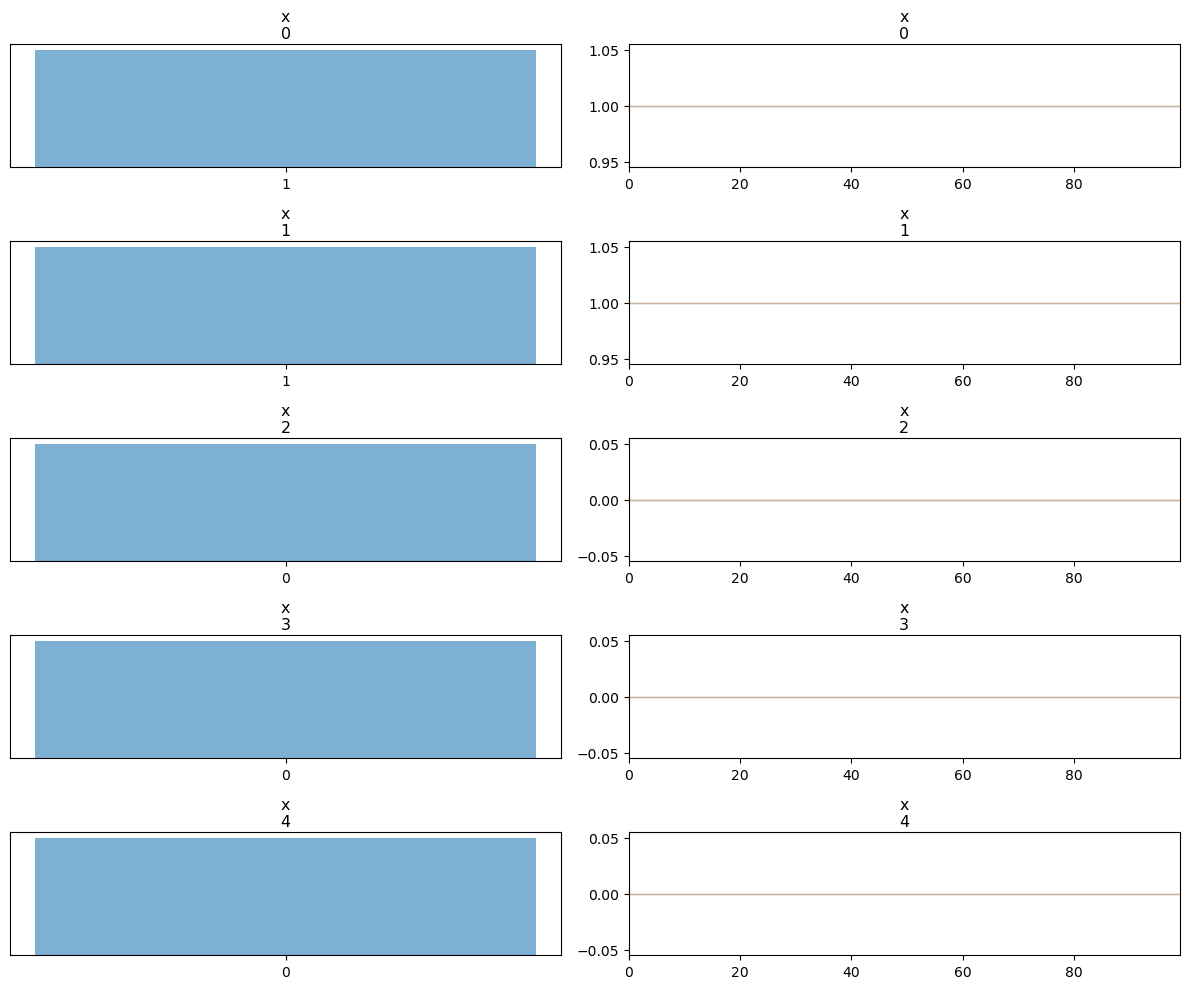

In [10]:
pm.plot_trace(trace, var_names=['x'], coords={'x_dim_0': np.arange(5)}, compact=False);

In [11]:
## Metropolis did not move from the initial state we provided
np.unique(trace.posterior['x'] == init_state)

array([ True])

In [12]:
# it took 1500+ seconds to sample
utils.save_trace(trace,f'haplotypes_pymc_genotypes_{len(genotypes)}.nc')